#### Week 1: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Project 1.3

# Overview

Welcome to the final notebook for Week 1! Take a look at all the ground we've covered so far:
- Chunking/splitting
- Vectorization of text
- Combining with metadata
- Saving to disk
- Class Configuration
- Data Indexing
- Keyword search
- Vector search
- OPTIONAL: Searching with Filters

We are now prepared to move on to a very important topic, **Retrieval Evaluation**.  I hope you've noticed that the search results will differ (sometimes slightly, sometimes by a lot) depeding on which search method you used: `keyword_search` or `vector_search`.  As humans, it's fairly easy for us to determine whether the returned search results are relevant to the query that was submitted, (though even here there will be differing opinions on result relevance).  But how do we systematically determine which search method is better in general?  And how do we measure the performance of our retrieval system if we change one of it's parameters, say use a different embedding model?  

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#external files
from preprocessing import FileIO

# from weaviate_interface import WeaviateClient
from weaviate_interface import WeaviateClient
from retrieval_evaluation import calc_hit_rate_scores, calc_mrr_scores, record_results
from reranker import ReRanker

#external libraries
from llama_index.finetuning import EmbeddingQAFinetuneDataset
import plotly.express as px

#standard library imports
from typing import List, Any, Dict, Tuple, Union
import time
import os

# utilities
from tqdm import tqdm
from rich import print
from dotenv import load_dotenv
env = load_dotenv('./.env', override=True)

### Load QA dataset

In [16]:
golden_dataset = EmbeddingQAFinetuneDataset.from_json("./data/golden_dataset.json")
len(golden_dataset.queries)
list(golden_dataset.queries.values())
golden_dataset.

["How did Les Brown's mother react when she saw him drinking from a white-only water fountain?",
 "Why did Les Brown's mother apologize to him after beating him?",
 'How does Apollo Ohno define a "life well-lived" for himself?',
 'Why does Apollo Ohno believe it is important to help others find their inner flame and overcome their limitations?',
 "How did Wall Street Trapper's experience in prison lead to a realization about his relationship with money?",
 'Why does Wall Street Trapper believe that changing one\'s relationship with money can change their position on the "chessboard" of life?',
 'How does the microbiome communicate with mitochondria in our bodies?',
 'Why does Dr. Gundry recommend smearing newborn babies in vaginal fluid to pass on the microbiome?',
 "How does the practice of looking for hearts help in changing one's perspective and mindset?",
 'Why does Mel Robbins emphasize the importance of using multiple tools and habits in addition to the high-five habit for person

### Instantiate Weaviate client and set Class name

In [17]:
client = WeaviateClient(os.environ['WEAVIATE_API_KEY'], os.environ['WEAVIATE_ENDPOINT'])
class_name = 'Final_test'

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

In [18]:
resp = client.hybrid_search('Why do some people perceive Jordan Peterson as being mean, even though he believes he is trying to help them see the reality of hierarchies and the need for personal growth?', class_name, limit=5)

### Evaluate Retrieval methods

In [21]:
def execute_evaluation( dataset: EmbeddingQAFinetuneDataset, 
                        class_name: str, 
                        retriever: WeaviateClient,
                        reranker: ReRanker=None,
                        alpha: float=0.5,
                        retrieve_limit: int=5,
                        results_top_k: int=5,
                        rerank_top_k: int=5,
                        chunk_size: int=256,
                        display_properties: List[str]=['doc_id', 'content']
                        ) -> Tuple[int, int, int]:

    if results_top_k > retrieve_limit:  # we don't want to retrieve less results than the top_k that we want to see returned
        retrieve_limit = results_top_k
        
    reranker_name = reranker.model_name if reranker else "None"
    
    results_dict = {'n':retrieve_limit, 
                    'top_k': results_top_k,
                    'alpha': alpha,
                    'Retriever': retriever.model_name_or_path, 
                    'Ranker': reranker_name,
                    'chunk_size': chunk_size,
                    'kw_hit_rate': 0,
                    'kw_mrr': 0,
                    'vector_hit_rate': 0,
                    'vector_mrr': 0,
                    'hybrid_hit_rate':0,
                    'hybrid_mrr': 0,
                    'total_misses': 0,
                    'total_questions':0
                    }
    if reranker:
        results_dict['rerank_top_k'] = rerank_top_k  # have to build the results_dict before we can add this information
        
    start = time.perf_counter()
    for query_id, q in tqdm(dataset.queries.items(), 'Queries'):
        results_dict['total_questions'] += 1
        
        #make Keyword, Vector, and Hybrid calls to Weaviate host
        try:
            kw_response = retriever.keyword_search(request=q, class_name=class_name, limit=retrieve_limit, display_properties=display_properties)
            vector_response = retriever.vector_search(request=q, class_name=class_name, limit=retrieve_limit, display_properties=display_properties)
            hybrid_response = retriever.hybrid_search(request=q, class_name=class_name, alpha=alpha, limit=retrieve_limit, display_properties=display_properties)           
            #rerank returned responses if reranker is provided
            if reranker:
                kw_response = reranker.rerank(kw_response, q, top_k=rerank_top_k)
                vector_response = reranker.rerank(vector_response, q, top_k=rerank_top_k)
                hybrid_response = reranker.rerank(hybrid_response, q, top_k=rerank_top_k)
            
            #collect doc_ids to check for document matches (include only results_top_k)
            kw_doc_ids = {result['doc_id']:i for i, result in enumerate(kw_response[:results_top_k], 1)}
            vector_doc_ids = {result['doc_id']:i for i, result in enumerate(vector_response[:results_top_k], 1)}
            hybrid_doc_ids = {result['doc_id']:i for i, result in enumerate(hybrid_response[:results_top_k], 1)}
            
            #extract doc_id for scoring purposes
            doc_id = dataset.relevant_docs[query_id][0]
     
            #increment hit_rate counters and mrr scores
            if doc_id in kw_doc_ids:
                results_dict['kw_hit_rate'] += 1
                results_dict['kw_mrr'] += 1/kw_doc_ids[doc_id]
            if doc_id in vector_doc_ids:
                results_dict['vector_hit_rate'] += 1
                results_dict['vector_mrr'] += 1/vector_doc_ids[doc_id]
            if doc_id in hybrid_doc_ids:
                results_dict['hybrid_hit_rate'] += 1
                results_dict['hybrid_mrr'] += 1/hybrid_doc_ids[doc_id]

            # if no hits, let's capture that
            else:
                results_dict['total_misses'] += 1
                
        except Exception as e:
            print(e)
            continue

    #use raw counts to calculate final scores
    calc_hit_rate_scores(results_dict)
    calc_mrr_scores(results_dict)
    
    end = time.perf_counter() - start
    print(f'Total Processing Time: {round(end/60, 2)} minutes')
    record_results(results_dict, chunk_size, './', as_text=True)
    return results_dict

### Run evaluation over golden dataset

In [22]:
# bge = ReRanker(model_name='BAAI/bge-reranker-base')

In [23]:
execute_evaluation(golden_dataset, class_name, client, reranker=None, alpha=0.3, retrieve_limit=10, results_top_k=5)

Queries: 100%|█████████████████████████████████████████████████████████████████| 250/250 [01:49<00:00,  2.29it/s]


Total Processing Time: 1.82 minutes

{'n': 10,
 'top_k': 5,
 'alpha': 0.3,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'Ranker': 'None',
 'chunk_size': 256,
 'kw_hit_rate': 0.68,
 'kw_mrr': 0.55,
 'vector_hit_rate': 0.4,
 'vector_mrr': 0.29,
 'hybrid_hit_rate': 0.71,
 'hybrid_mrr': 0.56,
 'total_misses': 73,
 'total_questions': 250}

# Assignment 2.3 - Build a Hybrid Search method
**Implement a hybrid search method on the Weaviate python client**. 

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.
- `fusion_type` is one of the hybrid search parameters.  Leave this value as [**`relativeScoreFusion`**](https://weaviate.io/blog/hybrid-search-fusion-algorithms) in your code, doing so will ensure that you are using Weaviate's preferred ranking alogrithm for hybrid search. 

In [ ]:
#configure search constants
class_name = None
query = None
query_embedding = None

#design hybird search query
'''
Get objects using bm25 and vector, then combine the results using a reciprocal ranking algorithm.

Args
----
query: str
    User query.
class_name: str
    Class (index) to search.
properties: List[str]
    List of properties to search across (using BM25)
alpha: float=0.5
    Weighting factor for BM25 and Vector search.
    alpha can be any number from 0 to 1, defaulting to 0.5:
        alpha = 0 executes a pure keyword search method (BM25)
        alpha = 0.5 weighs the BM25 and vector methods evenly
        alpha = 1 executes a pure vector search method
limit: int=10
    Number of results to return.
display_properties: List[str]=None
    List of properties to return in response.
    If None, returns all properties.
'''

response = (client.query
            
 .get(None, None). #reminder that the properties param here refers to the "display_properties"
            
 # use near_vector our search method, and only search over the "content" property
 .with_hybrid(query=None,
              alpha=None,
              vector=None,
              properties=None,
              fustion_type='relativeScoreFusion')

 # instead of "score", vector search can return a "distance" property for scoring, the smaller the distance, the more semantically similar is the result
 .with_additional(['score', 'distance', 'explainScore'])
            
 # limit the returned results to the top-3 ranked hits
 .with_limit(None)
            
 # execute the search with the "do" command
 .do()
)

# To show cleaned up results we'll use the built-in format response method
print(client.format_response(response, class_name))

# Evaluation of Reranker Effect on Latency

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.95it/s]


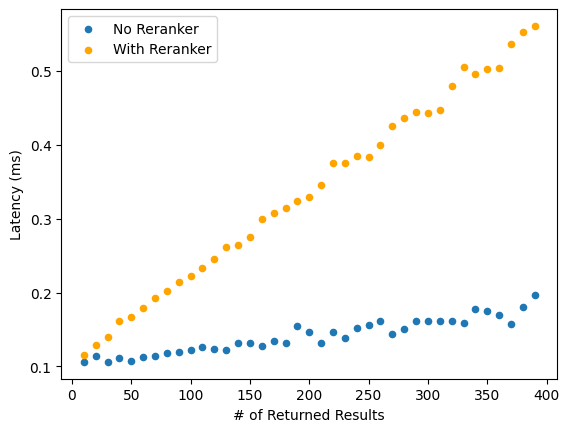

In [65]:
def time_search(limit: int, rerank: bool=True):
    start = time.perf_counter()
    response = client.keyword_search('how do I make a million dollars', 'Impact_theory_minilm_256', limit=limit, display_properties=['content', 'title'], top_k=5, rerank_results=rerank)
    end = time.perf_counter() - start
    return round(end, 3)

false_times = []
for x in tqdm(range(10, 400, 10)):
    false_times.append((time_search(x, rerank=False), x))
    

ranked_times = []
for x in tqdm(range(10, 400, 10)):
    ranked_times.append((time_search(x, rerank=True), x))

import pandas as pd

false_df = pd.DataFrame(false_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = false_df.plot.scatter(x='n', y='time', label='No Reranker')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')

In [ ]:
{'n': 160,
 'top_k': 5,
 'alpha': 0.3,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'Ranker': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
 'chunk_size': 256,
 'kw_hit_rate': 0.72,
 'kw_mrr': 0.57,
 'vector_hit_rate': 0.62,
 'vector_mrr': 0.51,
 'hybrid_hit_rate': 0.74,
 'hybrid_mrr': 0.58,
 'total_misses': 66,
 'total_questions': 250,
 'rerank_top_k': 5}